# **Histopathologic Cancer Detection: Model and Evaluation**
Saloni Sharma
***
This notebook includes the model, evaluation and prediction of the test dataset.

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.random import seed
seed(101)

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import cv2
import os
import shutil

Below, I load the dataframes that were generated in the EDA notebook. The train_df.csv file includes the paths to the training images as well as their IDs and labels. The test_df.csv file includes the paths to images and their IDs for the test dataset.

In [2]:
# Load Files
df = pd.read_csv("../input/hw5-dataframes/train_df.csv")
test = pd.read_csv("../input/hw5-dataframes/test_df.csv")

In [3]:
print(df.shape)
print(test.shape)

(220023, 3)
(57458, 2)


In [4]:
df.head(2)

,path,id,label
0,../input/histopathologic-cancer-detection/trai...,d43c081bafa286f9c1f7e921883f26ceafebc912,1
1,../input/histopathologic-cancer-detection/trai...,092d0eedebce504847715ee046b6ad74b57599b4,0


***
# **Set Up Before Model**

## Training and Validation Sets
Below, I create the training and validation sets using the training images provided. Instead of all 220K images, I use 100,000 images in order to have a shorter training time. First, I randomly choose 50K images with label 1 and another 50K images with label 0. This will prevent any significant skew that can be caused by an inherent imbalance in the data distribution. Second, I split the 100K images into the training and validation sets with 80% and 20% of images, respectively.

In [5]:
# Based on https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

N = 50000 #number of images we want per class label

# get 50K with label 0, another 50K with label 1
df_0 = df[df.label == 0].sample(N, random_state = 101)
df_1 = df[df.label == 1].sample(N, random_state = 101)

# combine both dataframes into one with 100K
df100 = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
print(df100.label.value_counts())

1    50000
0    50000
Name: label, dtype: int64


In [6]:
# Train set is 80% and validation set is 20% of 'df100' dataset

y = df100.label #stratify will give equal number of labels per class in each set

# split the 100K images into train and validation sets
train_df, val_df = train_test_split(df100, test_size=0.20, random_state=101, stratify=y)

print(train_df.shape)
print(val_df.shape)

(80000, 3)
(20000, 3)


In [7]:
val_df.label.value_counts()

1    10000
0    10000
Name: label, dtype: int64

In [8]:
train_df.label.value_counts()

1    40000
0    40000
Name: label, dtype: int64

## Create Directories
Here, I separate and copy the images into subdirectories based on their label. I create a base directory, and then, two subdirectories for the training and validiation sets. Each of those two directories have two more subdirectories for each class (no_cancer and yes_cancer). 

In [9]:
# Create a new directory
os.mkdir('base_dir')

# Subdirectories for both train and val sets
os.mkdir('base_dir/train_dir')
os.mkdir('base_dir/val_dir')

# More subdirectories for each label
# train_dir
os.mkdir('base_dir/train_dir/no_cancer')
os.mkdir('base_dir/train_dir/yes_cancer')

# val_dir
os.mkdir('base_dir/val_dir/no_cancer')
os.mkdir('base_dir/val_dir/yes_cancer')

In [10]:
%%time
# Copy images into subdirectories

# get image ids 
train_ids = train_df.id.values
val_ids = val_df.id.values

# place images into corresponding directories
# training set
for img_id in train_ids:
    fname = img_id + '.tif'
    # get label for image file
    flabel = df100.loc[df100.id==img_id].label.values[0]
    if flabel == 0:
        subdir = 'no_cancer'
    elif flabel == 1:
        subdir = 'yes_cancer'
    # copy image from source location to new location
    src_loc = df100.loc[df100.id==img_id].path.values[0]
    new_loc = os.path.join('base_dir/train_dir', subdir, fname)
    shutil.copyfile(src_loc, new_loc)

# validation set
for img_id in val_ids:
    fname = img_id + '.tif'
    # get label for image file
    flabel = df100.loc[df100.id==img_id].label.values[0]
    if flabel == 0:
        subdir = 'no_cancer'
    elif flabel == 1:
        subdir = 'yes_cancer'
    # copy image from source location to new location
    src_loc = df100.loc[df100.id==img_id].path.values[0]
    new_loc = os.path.join('base_dir/val_dir', subdir, fname)
    shutil.copyfile(src_loc, new_loc)

CPU times: user 51min 30s, sys: 28.6 s, total: 51min 58s
Wall time: 1h 7min 48s


In [11]:
# Check the number of images is same as in dataframes
print("train_dir:")
print(len(os.listdir('base_dir/train_dir/no_cancer')))
print(len(os.listdir('base_dir/train_dir/yes_cancer')))

print("\nval_dir:")
print(len(os.listdir('base_dir/val_dir/no_cancer')))
print(len(os.listdir('base_dir/val_dir/yes_cancer')))

train_dir:
40000
40000

val_dir:
10000
10000


***
# **Train Model**
This section includes the model creation process. First, I start with processing the images, developing the model architecture and training the model with the training dataset.

## Prepare Generators

In [80]:
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'

num_train_samples = len(train_df)
num_val_samples = len(val_df)
train_batch_size = 32
val_batch_size = 32
IMAGE_SIZE = 96

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [81]:
preprocess_func = lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x
datagen = ImageDataGenerator(preprocessing_function = preprocess_func,
                            horizontal_flip=True,vertical_flip=True)
# training images
train_generator = datagen.flow_from_directory(train_path, target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size, class_mode='binary')
# validation images
val_generator = datagen.flow_from_directory(val_path, target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size, class_mode='binary')
# validation images used in evaluation
test_generator = datagen.flow_from_directory(val_path, target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1, class_mode='binary', shuffle=False)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


## Build Model

In [82]:
# Model 

# Parameters
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
# Dropout for regularization
dropout_conv = 0.3
dropout_dense = 0.5

# Initialize model
model = Sequential()

# Block 1
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Block 4: Dense 
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_30 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
activation_30 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 44, 44, 64)       

In [83]:
# Compile the model
# binary cross entropy is good for binary classification problems
model.compile(optimizer=Adam(lr=0.01), loss = "binary_crossentropy", 
              metrics=["accuracy"])

## Train Model

In [84]:
%%time
# Based off on https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

# training stops early if validation loss doesn't improve (decrease)
earlystopper = EarlyStopping(monitor='val_loss', mode='auto', patience=10, 
                             verbose=1, restore_best_weights=True)
# reduce learning rate based on validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=1, 
                              verbose=1, factor=0.2)

callbacks_list = [earlystopper, reduce_lr]

history = model.fit(train_generator, steps_per_epoch=train_steps, 
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    epochs=20, verbose=0,
                   callbacks=callbacks_list)


Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.599999814061448e-05.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.199999628122896e-06.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 6.399999165296323e-07.

Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.2799998785339995e-07.

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.5599996433811613e-08.

Epoch 00014: ReduceLROnPlateau reducing learning rate to 5.1199993578165965e-09.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.023999907090456e-09.
Restoring model weights from the end of the best epoch.

Epoch 00016: ReduceLROnPlateau reducing learning rate to 2.0479997697719911e-10.
Epoch 00016: early stopping
CPU times: user 37min

In [96]:
# Save model architecture and weights
# Then, this file can be loaded, instead of re-running training process
model.save("model.h5")

***
# **Evaluation**
Here, I view some metrics to evaluate how well the model performed in comparison to the validation set.

In [97]:
model.metrics_names

['loss', 'accuracy']

## View Accuracy and Loss

In [98]:
# modified version of function from 
# https://www.kaggle.com/twhitehurst3/cancer-detect-keras-92-acc

# Plot accuracy and validation for both sets
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(16,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], 'lightcoral', label="Train Loss")
    ax[0].plot(history.epoch, history.history["val_loss"], 'cornflowerblue', label="Validation Loss")
    ax[0].set_xlabel("Epochs")
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], 'lightcoral', label="Train Accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], 'cornflowerblue', label="Validation Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[0].legend()
    ax[1].legend()

In [99]:
# View the accuracy for each dataset
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
valid_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"Validation Accuracy: {val_acc}; Train Accuracy: {train_acc}")

Validation Accuracy: 0.897350013256073; Train Accuracy: 0.902525007724762


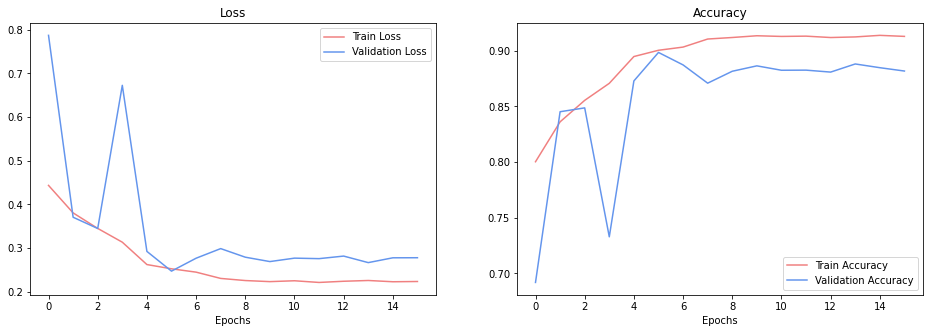

In [100]:
show_final_history(history)

## Evaluate Validation Set

In [101]:
# Validation predictions

# use trained model to predict labels for validation set (test_generator)
val_pred = model.predict(test_generator, verbose=1)
# false positive rate, true positive rate
fpr, tpr, thresholds = roc_curve(test_generator.classes, val_pred)
auc_val = auc(fpr, tpr)
print("AUC:", auc_val)

20000/20000 [==============================] - 59s 3ms/step
AUC: 0.9708209999999999


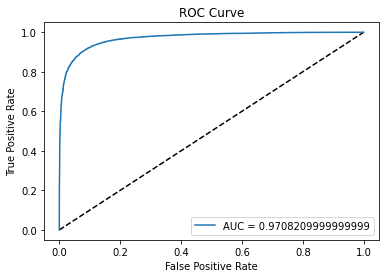

In [102]:
# Based on https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb 

# Plot ROC curve of validation predictions

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {auc_val}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best');

***
# **Predict Test Data**
Finally, I use the trained model to make predictions for the test dataset and create the submission file with probabilities for each image.

In [103]:
# Test df where the paths and ids are stored
test.head(3)

,path,id
0,../input/histopathologic-cancer-detection/test...,a7ea26360815d8492433b14cd8318607bcf99d9e
1,../input/histopathologic-cancer-detection/test...,59d21133c845dff1ebc7a0c7cf40c145ea9e9664
2,../input/histopathologic-cancer-detection/test...,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb


In [90]:
%%time
# Predict labels for test data
# Based on https://www.kaggle.com/twhitehurst3/cancer-detect-keras-92-acc 

# initialize submission dataframe
submission = pd.DataFrame()
file_batch = 10000
num_images = test.shape[0]

# make predictions for test data in batches of images
for i in range(0, num_images, file_batch):
    # get batch of image files
    batch_df = test[i:i+file_batch].copy()
    # read all images in current batch
    batch_df['image'] = batch_df.path.map(cv2.imread) 
    image_arrays = np.stack(batch_df.image.values)
    # ("de-meaned" array) / (std of array)
    image_arrays = (image_arrays - image_arrays.mean()) / image_arrays.std()
    # predict labels for the test dataset
    batch_pred = model.predict(image_arrays, verbose=0)
    batch_df['label'] = batch_pred
    submission = pd.concat([submission, batch_df[['id', 'label']]])
    print(f"Completed batch of images: {i} - {i+file_batch}")

Completed batch of images: 0 - 10000
Completed batch of images: 10000 - 20000
Completed batch of images: 20000 - 30000
Completed batch of images: 30000 - 40000
Completed batch of images: 40000 - 50000
Completed batch of images: 50000 - 60000
CPU times: user 32.3 s, sys: 22.1 s, total: 54.4 s
Wall time: 5min 54s


In [91]:
submission.head(3)

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.468713
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.086067
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.106600


In [92]:
# Save submission file
submission.to_csv("submission.csv", index=False, header=True) #make csv file

In [93]:
pd.read_csv("submission.csv").head(3)

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.468713
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.086067
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.106600


***
# **Resources**

Kaggle Notebooks:
* https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing
* https://www.kaggle.com/twhitehurst3/cancer-detect-keras-92-acc
* https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb
* https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93
